Notebooks con el tema de Marginación

23b-Group-block-hex
23c-Group-block-hex
29-Population-correlation

## Importing libraries

In [2]:
import os
import sys

import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import esda
import pysal
import libpysal as lps
from splot import esda as esdaplot
from pandas.api.types import CategoricalDtype

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

2023-03-01 19:01:12 Configured OSMnx 1.1.1
2023-03-01 19:01:12 HTTP response caching is on


## Downloading data

Pop data

In [4]:
pop_hex9 = aup.gdf_from_db('censo_10_20_hexres8','censo')
pop_hex9.head(2)

,hex_id_8,pobtot,pobfem,pobmas,p_0a2,p_0a2_f,p_0a2_m,p_3ymas,p_3ymas_f,p_3ymas_m,...,R_VivHab_20,R_VivDes_20,Z_RVivHab_20,R_VivHab_10,Z_RVivHab_10,Chng_RVivHab_10,DensPob_10_20,R_TVivDes_10_20,geometry,city
0,8849950593fffff,2584.0,1325.0,1256.0,69.0,33.0,20.0,2495.0,1277.0,1218.0,...,0.856070,0.062578,0.09619,0.0,None,0.856070,3.095422,None,"POLYGON ((-98.95532 19.76038, -98.95079 19.763...",ZMVM
1,8849958da5fffff,10322.0,5310.0,5003.0,435.0,199.0,205.0,9854.0,5086.0,4768.0,...,0.908537,0.060976,0.46020,0.0,None,0.908537,30.829713,None,"POLYGON ((-98.94151 19.41992, -98.93699 19.422...",ZMVM


In [5]:
pop_hex9.city.unique()

array(['ZMVM', 'Guadalajara', 'Monterrey'], dtype=object)

Marginalization data

In [6]:
gdf_tmp = pop_hex9.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

In [7]:
query = f"SELECT * FROM censo.hex_bins_marg_2020 WHERE (ST_Intersects(geometry, \'SRID=4326; {poly_wkt}\'))"
marg_hex9 = aup.gdf_from_query(query, geometry_col='geometry')
print(marg_hex9.shape)
marg_hex9.head(2)

(6406, 17)


,geometry,hex_id_8,CVEGEO,pobtot,p6a14nae,sbasc,psdss,ovsde,ovsee,ovsae,ovpt,ovsref,ovsint,ovscel,ovhac,im_2020,imn_2020
0,"POLYGON ((-99.17740 19.48241, -99.17776 19.487...",884995b8c1fffff,09002,14474.150,11.159615,39.639160,60.006165,0.094840,0.109755,0.752394,0.921807,8.358856,45.407722,16.135150,54.746320,123.545098,0.965088
1,"POLYGON ((-99.17884 19.50300, -99.17848 19.497...",884995b88dfffff,09002,5324.688,12.022201,22.668638,27.020708,0.101111,0.016225,5.099980,1.091457,5.453633,28.146427,7.906191,28.952435,123.916076,0.967986


## Merging geodataframes

In [8]:
fields_to_keep = ['hex_id_8','pobtot','tothog','hogjef_f','10_pobtot','10_tothog','10_hogjef_f','geometry','city']
pop_hex9_f = pop_hex9[fields_to_keep]
pop_hex9_f.head(1)

,hex_id_8,pobtot,tothog,hogjef_f,10_pobtot,10_tothog,10_hogjef_f,geometry,city
0,8849950593fffff,2584.0,684.0,179.0,2323.0,547.0,76.0,"POLYGON ((-98.95532 19.76038, -98.95079 19.763...",ZMVM


In [9]:
fields_to_keep = ['hex_id_8','im_2020','imn_2020','geometry']
marg_hex9_f = marg_hex9[fields_to_keep]
marg_hex9_f.head(1)

,hex_id_8,im_2020,imn_2020,geometry
0,884995b8c1fffff,123.545098,0.965088,"POLYGON ((-99.17740 19.48241, -99.17776 19.487..."


In [10]:
pop_marg_hex9 = pop_hex9_f.merge(marg_hex9_f, on='hex_id_8')
pop_marg_hex9.head(1)

,hex_id_8,pobtot,tothog,hogjef_f,10_pobtot,10_tothog,10_hogjef_f,geometry_x,city,im_2020,imn_2020,geometry_y
0,8849950593fffff,2584.0,684.0,179.0,2323.0,547.0,76.0,"POLYGON ((-98.95532 19.76038, -98.95079 19.763...",ZMVM,118.096535,0.922526,"POLYGON ((-98.95114 19.76845, -98.95603 19.770..."


## Data analysis

Calculating change in %hogjef from 2010 to 2020

In [11]:
pop_marg_hex9['%hogjef_f'] = (pop_marg_hex9['hogjef_f'] / pop_marg_hex9['tothog'])*100
pop_marg_hex9['%10_hogjef_f'] = (pop_marg_hex9['10_hogjef_f'] / pop_marg_hex9['10_tothog'])*100
pop_marg_hex9['chg_%hogjef_f'] = pop_marg_hex9['%hogjef_f'] - pop_marg_hex9['%10_hogjef_f']
pop_marg_hex9.head(2)

,hex_id_8,pobtot,tothog,hogjef_f,10_pobtot,10_tothog,10_hogjef_f,geometry_x,city,im_2020,imn_2020,geometry_y,%hogjef_f,%10_hogjef_f,chg_%hogjef_f
0,8849950593fffff,2584.0,684.0,179.0,2323.0,547.0,76.0,"POLYGON ((-98.95532 19.76038, -98.95079 19.763...",ZMVM,118.096535,0.922526,"POLYGON ((-98.95114 19.76845, -98.95603 19.770...",26.169591,13.893967,12.275624
1,8849958da5fffff,10322.0,2682.0,763.0,7725.0,1837.0,361.0,"POLYGON ((-98.94151 19.41992, -98.93699 19.422...",ZMVM,118.539489,0.925986,"POLYGON ((-98.94151 19.41992, -98.93699 19.422...",28.448919,19.651606,8.797313


Calculating marginalization categories

In [12]:
pop_marg_hex9['grado_marg'] = np.nan
pop_marg_hex9.loc[pop_marg_hex9.imn_2020>=0.966338 , 'grado_marg'] = 'Muy bajo'
pop_marg_hex9.loc[(pop_marg_hex9.imn_2020>=0.946436 ) & (pop_marg_hex9.imn_2020<0.966338), 'grado_marg'] = 'Bajo'
pop_marg_hex9.loc[(pop_marg_hex9.imn_2020>=0.926536) & (pop_marg_hex9.imn_2020<0.946436), 'grado_marg'] = 'Medio'
pop_marg_hex9.loc[(pop_marg_hex9.imn_2020>=0.8999) & (pop_marg_hex9.imn_2020<0.926536), 'grado_marg'] = 'Alto'
pop_marg_hex9.loc[pop_marg_hex9.imn_2020 < 0.8999, 'grado_marg'] = 'Muy alto'
pop_marg_hex9.head(2)

,hex_id_8,pobtot,tothog,hogjef_f,10_pobtot,10_tothog,10_hogjef_f,geometry_x,city,im_2020,imn_2020,geometry_y,%hogjef_f,%10_hogjef_f,chg_%hogjef_f,grado_marg
0,8849950593fffff,2584.0,684.0,179.0,2323.0,547.0,76.0,"POLYGON ((-98.95532 19.76038, -98.95079 19.763...",ZMVM,118.096535,0.922526,"POLYGON ((-98.95114 19.76845, -98.95603 19.770...",26.169591,13.893967,12.275624,Alto
1,8849958da5fffff,10322.0,2682.0,763.0,7725.0,1837.0,361.0,"POLYGON ((-98.94151 19.41992, -98.93699 19.422...",ZMVM,118.539489,0.925986,"POLYGON ((-98.94151 19.41992, -98.93699 19.422...",28.448919,19.651606,8.797313,Alto


Calculating average change in %hogjef_f by grado_marg

In [13]:
#Finding None values in 'chg_%hogjef_f' and changing them to 0
#First we create a boolean mask where there is nan in 'name'
#idx = pop_marg_hex9['chg_%hogjef_f'].isna()
#Then, in that boolean mask, we change 'chg_%hogjef_f' to 0
#pop_marg_hex9.loc[idx, 'chg_%hogjef_f'] = 0

#nodata = pop_marg_hex9.loc[idx]
#print(nodata)
#print(nodata['10_pobtot'].sum())

In [41]:
hogjef_f_bymarg = pop_marg_hex9.groupby('grado_marg').agg({'chg_%hogjef_f':np.nanmean})
hogjef_f_bymarg

,chg_%hogjef_f
grado_marg,
Alto,10.757931
Bajo,10.198740
Medio,10.783619
Muy alto,12.742203
Muy bajo,9.310988


In [42]:
#Order data
from pandas.api.types import CategoricalDtype

cat_list = ['Muy bajo','Bajo','Medio','Alto', 'Muy alto']

cat_size_order = CategoricalDtype(
    cat_list, 
    ordered=True)

hogjef_f_bymarg = hogjef_f_bymarg.reset_index()

hogjef_f_bymarg['grado_marg'] = hogjef_f_bymarg['grado_marg'].astype(cat_size_order)
hogjef_f_bymarg = hogjef_f_bymarg.sort_values('grado_marg')
hogjef_f_bymarg

,grado_marg,chg_%hogjef_f
4,Muy bajo,9.310988
1,Bajo,10.198740
2,Medio,10.783619
0,Alto,10.757931
3,Muy alto,12.742203


In [45]:
#ordering original pop_marg_hex9 data
cat_list = ['Muy bajo','Bajo','Medio','Alto', 'Muy alto']

cat_size_order = CategoricalDtype(
    cat_list, 
    ordered=True)

pop_marg_hex9 = pop_marg_hex9.reset_index()

pop_marg_hex9['grado_marg'] = pop_marg_hex9['grado_marg'].astype(cat_size_order)
pop_marg_hex9 = pop_marg_hex9.sort_values('grado_marg')
pop_marg_hex9

,index,hex_id_8,pobtot,tothog,hogjef_f,10_pobtot,10_tothog,10_hogjef_f,geometry_x,city,im_2020,imn_2020,geometry_y,%hogjef_f,%10_hogjef_f,chg_%hogjef_f,grado_marg
4934,4934,8848a205a1fffff,9799.0,2835.0,582.0,8307.0,2072.0,281.0,"POLYGON ((-100.31242 25.78360, -100.30767 25.7...",Monterrey,125.484553,0.980238,"POLYGON ((-100.30767 25.78653, -100.30810 25.7...",20.529101,13.561776,6.967324,Muy bajo
5163,5163,8848a204cbfffff,4091.0,1221.0,160.0,0.0,0.0,0.0,"POLYGON ((-100.41911 25.74513, -100.41436 25.7...",Monterrey,126.542463,0.988502,"POLYGON ((-100.42473 25.75260, -100.42430 25.7...",13.104013,NaN,NaN,Muy bajo
5636,5636,8848a2021dfffff,276.0,66.0,14.0,71.0,16.0,0.0,"POLYGON ((-100.26467 25.56692, -100.25993 25.5...",Monterrey,126.532279,0.988423,"POLYGON ((-100.25993 25.56985, -100.26035 25.5...",21.212121,0.000000,21.212121,Muy bajo
4287,4287,8849aa2c9dfffff,10346.0,3166.0,1054.0,7825.0,2105.0,403.0,"POLYGON ((-103.38106 20.57386, -103.37652 20.5...",Guadalajara,124.452742,0.972178,"POLYGON ((-103.38214 20.58424, -103.38667 20.5...",33.291219,19.144893,14.146326,Muy bajo
4286,4286,8849ab59b9fffff,2969.0,916.0,242.0,1508.0,337.0,65.0,"POLYGON ((-103.44614 20.68565, -103.44160 20.6...",Guadalajara,124.029943,0.968875,"POLYGON ((-103.44614 20.68565, -103.44160 20.6...",26.419214,19.287834,7.131380,Muy bajo
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2879,2879,8849950717fffff,420.0,110.0,27.0,0.0,0.0,0.0,"POLYGON ((-98.93851 19.65293, -98.93398 19.655...",ZMVM,109.438102,0.854889,"POLYGON ((-98.93922 19.66323, -98.94375 19.660...",24.545455,NaN,NaN,Muy alto
1169,1169,88499532bbfffff,36.0,7.0,0.0,34.0,7.0,0.0,"POLYGON ((-99.17118 19.79875, -99.16665 19.801...",ZMVM,114.902992,0.897579,"POLYGON ((-99.17608 19.80098, -99.17118 19.798...",0.000000,0.000000,0.000000,Muy alto
1824,1824,8849958893fffff,5177.0,1366.0,374.0,1776.0,427.0,87.0,"POLYGON ((-98.92581 19.32803, -98.92129 19.330...",ZMVM,113.844306,0.889309,"POLYGON ((-98.92581 19.32803, -98.92129 19.330...",27.379209,20.374707,7.004502,Muy alto
3327,3327,884995ae0dfffff,209.0,55.0,8.0,0.0,0.0,0.0,"POLYGON ((-99.28394 19.65040, -99.27941 19.653...",ZMVM,107.985140,0.843539,"POLYGON ((-99.28467 19.66071, -99.28920 19.657...",14.545455,NaN,NaN,Muy alto


Text(0, 0.5, 'Cambio en el porcentaje de hogares con jefatura femenina (2010 vs 2020)')

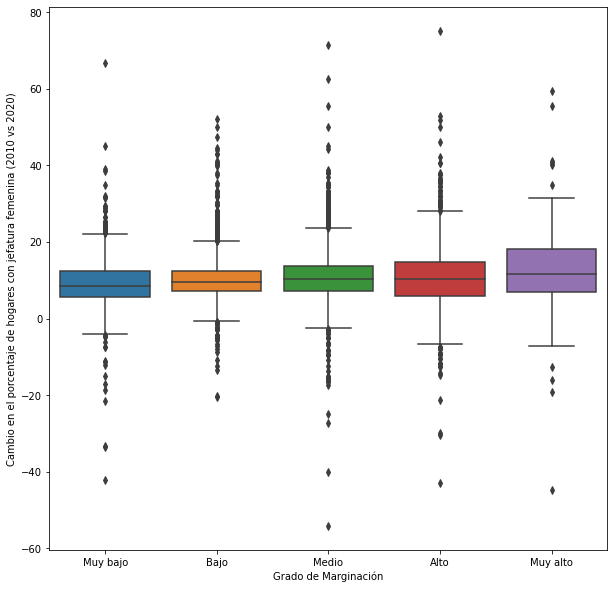

In [46]:
fig, ax = plt.subplots(figsize=(10,10))

x = np.array(pop_marg_hex9.grado_marg)
y = np.array(pop_marg_hex9['chg_%hogjef_f'])

sns.boxplot(x=x , y=y, ax=ax)

plt.xlabel('Grado de Marginación')
plt.ylabel('Cambio en el porcentaje de hogares con jefatura femenina (2010 vs 2020)')